# Impact of variants

We want to infer the effect of different variants onto the reproduction number. Given the positive tested COVID cases in a country we can infer the overall non variant specific effective spreading rate/reproduction number as described in \cite{dehning2020inferring}. 

Now let $y_v$ be the number of sequenced PCR tests, which correspond to variant $v$, let $n$ be the total number of sequenced tests and $\tau_{v,t}$ the relative fraction of the variant $v$ at timepoint $t$.
Assuming an independent sampling of the sequenced cases, the number of samples of a given variant $v$ is given by a Binomial distribution:

\begin{align}
 y_{v,t} \sim \text{Bin}(\tau_{v,t},n_t) \quad \forall v,t.
\end{align}


In [2]:
### Imports
import sys

sys.path.append("./covid19_inference")
import covid19_inference

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pickle
import os
import covid19_inference as cov19
from matplotlib.dates import DateFormatter,WeekdayLocator

n_threads = str(1) # per process
n_processes = 32
os.environ["MKL_NUM_THREADS"] = n_threads
os.environ["OMP_NUM_THREADS"] = n_threads
os.environ["NUMEXPR_NUM_THREADS"] = n_threads
os.environ["OPENBLAS_NUM_THREADS"] = n_threads

data_end = datetime.datetime(2021,7,24)

### Preprocess data

Here we load the variant data for chile i.e. $y_{v,t}$ and $n_{v,t}$. The resolution for the data is weekly, starting on mondays. Additionaly we download the new confirmed cases in chile with our previous developed download utils. You can find the documentation for the dataretrieval module [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).

In [3]:
# Load data variants
variants = pd.read_excel("./data/Chile_Variants_Updated_with_airports.xlsx",sheet_name="Variants_Count")
variants = variants.set_index('Lineage').T
variants.index.name = "Week"
variants.index = pd.to_datetime(variants.index + '-1', format='%V_%G-%u')
variants = variants.iloc[0:-1]
variant_names = ["B.1.1", "B.1.1.348", "B.1.1.7", "C.37", "P.1"]

# Load casenumbers chile and sum over weeks
jhu = covid19_inference.data_retrieval.JHU(True)
new_cases_obs = jhu.get_new(country="Chile",data_begin=variants.index[0],data_end=data_end)
jhu.download_all_available_data(force_download=True)

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local
INFO     [covid19_inference.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.


Let us take a short look into the data. We plot the total number of sampled pcr test such as the number of test which could be per variant and the reported cases in chile.

<ipython-input-5-a7852c4d039e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


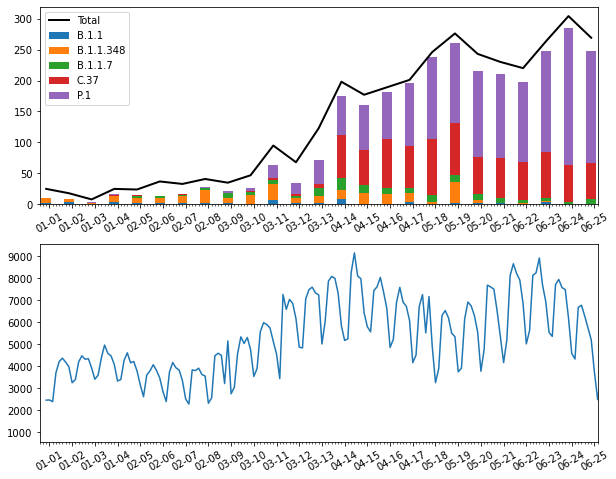

In [5]:
fig, axes = plt.subplots(2,1,figsize=(10,8))

s=0
for c in variants.columns:
    if c == "N_Total":
        continue
    axes[0].bar(variants.index,variants[c],width=3,label=c,bottom=s)
    s += variants[c]
axes[0] = covid19_inference.plot._timeseries(
    x=variants.index,
    y=variants["N_Total"],
    what="model",
    color="black",
    ax=axes[0],
    label="Total",
    lw=2
)
axes[0].legend()
axes[1] = covid19_inference.plot._timeseries(
    x=new_cases_obs.index,
    y=new_cases_obs,
    what="model",
    color="tab:blue",
    ax=axes[1],
)

# Date layout
date_form = DateFormatter("%m-%V")

# Markup
for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(variants.index[0]-datetime.timedelta(days=2), variants.index[-1]+datetime.timedelta(days=2))

fig.savefig("figures/overview.png",dpi=300)
fig.savefig("figures/overview.pdf",dpi=300)

### Create model

We defined different models and tested which one fits the dynamics best, have a look into `run_model.py` for more informations. For now we are running the default model with dirichlet likelihood and kernelized spread.

In [6]:
from run_model import create_model

likelihood="dirichlet"
spreading_dynamics="kernelized_spread"
influx_factor=0.2

this_model = create_model(
    likelihood=likelihood,
    spreading_dynamics=spreading_dynamics,
    variants=variants,
    new_cases_obs=new_cases_obs,
    factor_influx=influx_factor
)

INFO     [utils] pr_sigma_date_transient was set to default value 1.5
INFO     [utils] pr_sigma_lambda was set to default value 0.2
INFO     [utils] relative_to_previous was set to default value True
INFO     [utils] pr_factor_to_previous was set to default value 1.0
INFO     [utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [utils] pr_sigma_lambda was set to default value 0.2
INFO     [utils] relative_to_previous was set to default value True
INFO     [utils] pr_factor_to_previous was set to default value 1.0
INFO     [utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local
INFO     [covid19_inference.model.compartmental_models] Kernelized spread with variants
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.m

In [ ]:
multitrace, trace, multitrace_tuning, trace_tuning = cov19.robust_sample(
    this_model,
    draws=1500,
    tune=600,
    tune_2nd=1200,
    tuning_chains=32,
    final_chains=16,
    return_tuning=True,
    max_treedepth=10,
    target_accept=0.8,
    cores=32
)

WARNING  [pymc3] Tuning was enabled throughout the whole trace.
INFO     [pymc3] Auto-assigning NUTS sampler...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...


In [ ]:
_ = plt.plot(trace.sample_stats["lp"].T)

In [ ]:
_ = plt.plot(trace.sample_stats["tree_depth"].T)

In [ ]:
import pickle


# Save the trace (maybe we want to load it at a later point)
with open(f"./pickled/Variants-likelihood={likelihood}-spread_method={spreading_dynamics}-influx={influx_factor}_forecast.pickle", 'wb') as f:
    pickle.dump((this_model,trace),f)

## Stats and plots

First let's have a look if our chains converged to approx the same values. We can do that by computing the Rhat statistic.

In [ ]:
import arviz as az
az.rhat(trace).max()

In [ ]:
az.rhat(trace)

In [ ]:
az.ess(trace).min()

Next we want to create some basic plots, given our data and the model predictions. 

In [ ]:


def plot_timeseries(trace, model, key, var=None, ax=None, **kwargs):
    # Get data
    if var is None:
        var = np.array(trace.posterior[key])
        var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(16,8))

    axes = cov19.plot._timeseries(
        x=pd.date_range(this_model.sim_begin,this_model.sim_end),
        y=var[:,:],
        what="model",
        ax=ax,
        **kwargs
    )

    return axes

fig, axes = plt.subplots(2,1,figsize=(9,5), gridspec_kw={'height_ratios': [1, 2]})

# Plot new_cases
ax = plot_timeseries(trace,this_model,"new_cases",ax=axes[1])
cov19.plot._timeseries(new_cases_obs.index, new_cases_obs,what="data", ax=ax)
ax.set_ylim(0,10000)
ax.set_ylabel("Daily new cases")

# Plot lambda_t
ax = plot_timeseries(trace,this_model,"base_lambda_t",ax=axes[0])
ax.set_ylabel("Growth rate $\lambda_{eff}$")



for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(this_model.data_begin-datetime.timedelta(days=2), this_model.data_end+datetime.timedelta(days=2))
fig.tight_layout()

fig.savefig("./figures/lambda+cases.png",dpi=300)
fig.savefig("./figures/lambda+cases.pdf",dpi=300)

In [ ]:
# Plot lambda_t
ax = plot_timeseries(trace,this_model,"base_lambda_t")
ax.set_ylabel("Growth rate $\lambda_{eff}$")

In [ ]:
var = np.array(trace.posterior["Phi"])
var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])

fig, axes = plt.subplots(5,1,figsize=(9,3*5))
for v in range(len(variant_names)):
    plot_timeseries(trace,this_model,var=var[:,:,v], key="Phi",ax=axes[v])

for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(this_model.data_begin-datetime.timedelta(days=2), this_model.data_end+datetime.timedelta(days=2))
fig.tight_layout()

fig.savefig("./figures/influx.png",dpi=300)
fig.savefig("./figures/influx.pdf",dpi=300)

In [ ]:
fig, axes = plt.subplots(len(variant_names),1,figsize=(9,3*5))
for v, variant in enumerate(variant_names):
    ax = cov19.plot._timeseries(
        x=variants.index,
        y=np.array(trace.posterior.tau_w).reshape((trace.posterior.tau_w.shape[0]*trace.posterior.tau_w.shape[1],trace.posterior.tau_w.shape[2],trace.posterior.tau_w.shape[-1],))[:,:,v],
        what="model",
        ax=axes[v]
    )
    ax = cov19.plot._timeseries(
            x=variants.index + timedelta(days=3.5),
            y=variants[variants.columns[v]]/variants["N_Total"],
            what="data",
        ax=ax
    )
    ax.set_title(variant)
    
for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(this_model.data_begin-timedelta(days=2), this_model.data_end+timedelta(days=2))
    
    # 
    ax.set_ylabel(r"$\tau$")
fig.tight_layout()
fig.savefig("./figures/tau.png",dpi=300)
fig.savefig("./figures/tau.pdf",dpi=300)

In [ ]:
np.array(trace.posterior.tau).reshape((trace.posterior.tau.shape[0]*trace.posterior.tau.shape[1],trace.posterior.tau.shape[2],trace.posterior.tau.shape[-1],))[:,:,v].mean()

In [ ]:
import plot as pl
from rcParams import *

axes = pl.distribution(this_model, trace, "f_v", title="", dist_math="f",)
fig = axes[0].get_figure()

for i, var in enumerate(variant_names):
    axes[i].set_title(var)
    
axes[0].set_ylabel("Density")

fig.savefig("./figures/f.png",dpi=300)
fig.savefig("./figures/f.pdf",dpi=300)

In [ ]:
import plot as pl
from rcParams import *
relative_variant=4

trace.posterior['f_v'][...,2] = 1.
trace.posterior['f_tmp'] = trace.posterior['f_v']/trace.posterior['f_v'].isel(f_v_dim_0=relative_variant)

axes = pl.distribution(this_model, trace, "f_tmp", title="", dist_math="f",)
fig = axes[0].get_figure()

for i, var in enumerate(variant_names):
    axes[i].set_title(var)
    
axes[0].set_ylabel("Density")

fig.savefig("./figures/f.png",dpi=300)
fig.savefig("./figures/f.pdf",dpi=300)

In [ ]:
fig,axes = plt.subplots(len(variant_names),len(variant_names),figsize=(20,20))
for i in range(len(variant_names)):
    for j in range(len(variant_names)):
        x = np.array(trace.posterior.f_v[:,:,j]).flatten()
        y = np.array(trace.posterior.f_v[:,:,i]).flatten()
        axes[i,j].scatter(x,y, s=0.8)
        axes[i,j].set_xlim(0,2)
        axes[i,j].set_ylim(0,2)
        axes[i,j].set_xlabel(variant_names[j])
        axes[i,j].set_ylabel(variant_names[i])
fig.tight_layout()

In [ ]:
pl.distribution(this_model, trace, "factor_likelihood", title="", dist_math="f",)